# Оценка качества вин

In [2]:
#install packets
!pip3 install pylmnn
!pip3 install enn
!pip3 install matplotlib

In [93]:
import numpy as np
import pandas as pd
import matplotlib

from enn.enn import ENN
from pylmnn import LargeMarginNearestNeighbor as LMNN
from scipy.spatial.distance import euclidean, mahalanobis
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, RadiusNeighborsRegressor, NearestNeighbors
from sklearn.ensemble import RandomForestRegressor

# matplotlib.style.use('seaborn')
%pylab inline

from glob import glob
import os
import glob
import pickle
#pip install tqdm
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix
import statsmodels.stats.api as sm
from sklearn.linear_model import LinearRegression
import sys


Populating the interactive namespace from numpy and matplotlib


In [4]:

df_wine = pd.DataFrame() 
df1 = pd.DataFrame() 
path = 'LESSON07(13_11_2019)'
PATH_TO_DATA = '..\HW_13_wine_dataset'

pd.set_option('precision', 3)
i = 1
csv_file_path = glob.glob(os.path.join(path, "HW_13_wine_dataset", "winequality-red.csv"))
for file in csv_file_path:
    df1 = pd.read_csv(file, sep=';').assign(color='red')
csv_file_path = glob.glob(os.path.join(path, "HW_13_wine_dataset", "winequality-white.csv"))
for file in csv_file_path:
    df =pd.read_csv(file, sep=';').assign(color='white')
df = df.append(df1)
#print(df)
df['color'].value_counts()

white    4898
red      1599
Name: color, dtype: int64

Text(0.5, 0, 'Quality')

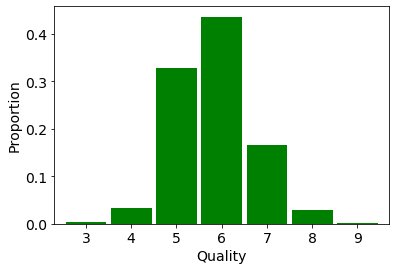

In [5]:
wine = df.sample(frac=1) #перемішали
wine
#распределение экспертных оценок вин (quality) в выборке:
stat = wine.groupby('quality')['quality'].agg(lambda x : float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="g")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Оценим признак, чтобы могли заранее предположить, какую оценку получит какое-то новое вино, которого в выборке нет. Чтобы смоделировать такую ситуацию, отделим 25% выборки для контроля качества предсказания:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(wine.ix[:, wine.columns != 'quality'], wine['quality'], test_size=0.25, 
                                                    stratify=wine[['color', 'quality']])
#разбить массивы или матрицы на случайные наборы поездов и тестов


C:\Users\Olya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\Olya\Anaconda3\lib\site-packages\pandas\core\indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


In [7]:
X_train['color'] = X_train['color'].apply(lambda x : -1 if x == 'red' else 1)
X_test['color'] = X_test['color'].apply(lambda x : -1 if x == 'red' else 1)

In [8]:
#Если у нас нет больше никакой информации о винах, то наше лучшее предположение об оценке — среднее имеющихся в обучающей выборке
y_train #среднее "quality" для тренировочных значений (75%)

1320    5
840     7
1129    7
4253    4
4149    7
       ..
436     5
2512    6
1432    6
435     5
3       6
Name: quality, Length: 4872, dtype: int64

In [9]:
np.mean(y_train)  #среднее "quality" для тренировочных значений (4872 - 75%)

5.817733990147783

In [10]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_train), y_train)) #cреднеквадратичнaa ошибкa на обучающей выборке

0.8735940831862377

In [11]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_test), y_test)) #cреднеквадратичнaa ошибкa на тестовойвыборке
#На тестовой выборке ошибка больше, поскольку среднее мы оценивали по обучающей. Это естественный эффект.

0.8719705746838052

In [12]:
wine.groupby('color')['color'].count() #цвет вина

color
red      1599
white    4898
Name: color, dtype: int64

Text(0.5, 0, 'Quality')

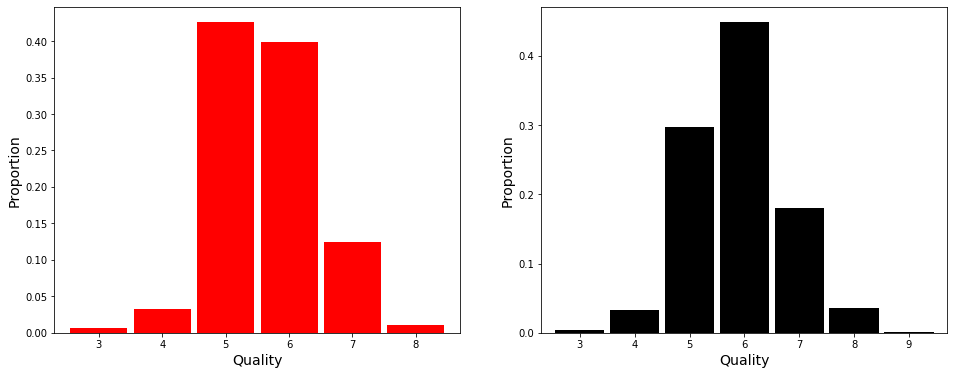

In [13]:
#для красного pаспределениe оценок
plt.figure(figsize(16,6))
plt.subplot(121)
stat_red = wine[wine['color'] == 'red'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['color'] == 'red'].shape[0])
stat_red.plot(kind='bar', color='r', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)
#для белого pаспределениe оценок
plt.subplot(122)
stat_white = wine[wine['color'] == 'white'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['color'] == 'white'].shape[0])
stat_white.plot(color='black', kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)
#pаспределения оценок 'Quality' по 'color' довольно сильно отличаются

In [14]:
tmeans = sm.CompareMeans(sm.DescrStatsW(wine[wine['color'] == 'white']['quality']), 
                         sm.DescrStatsW(wine[wine['color'] == 'red']['quality'])) 
# sm.DescrStatsW(значение = 0, альтернатива = 'двусторонняя') - z-тест нулевой гипотезы, что среднее значение равно значению
# sm.CompareMeans - класс для сравнения двух образцов
tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]
#ttest_ind - nроверка на нулевую гипотезу идентичных средств

4.888069044201999e-22

In [15]:
#95% доверительный интервал для разности средних оценок():
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.1929300940401796, 0.29084357932805205)

In [28]:
#Чтобы уточнить наше предсказание, можно оценку каждого вина предсказывать средним по оценкам вин такого же типа в выборке:
#regressor = LinearRegression()

In [52]:
regressor = LinearRegression()
regressor.fit(np.array(X_train['color']).reshape(-1,1), y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [54]:
y_train_predictions = regressor.predict(np.array(X_train['color']).reshape(-1,1))
y_test_predictions = regressor.predict(np.array(X_test['color']).reshape(-1,1))

In [56]:
sqrt(mean_squared_error(y_train_predictions, y_train))

0.8671965001753594

In [57]:
sqrt(mean_squared_error(y_test_predictions, y_test))
#Ошибки предсказания немного уменьшились

0.8662137838266156

Text(0, 0.5, 'Estimated quality')

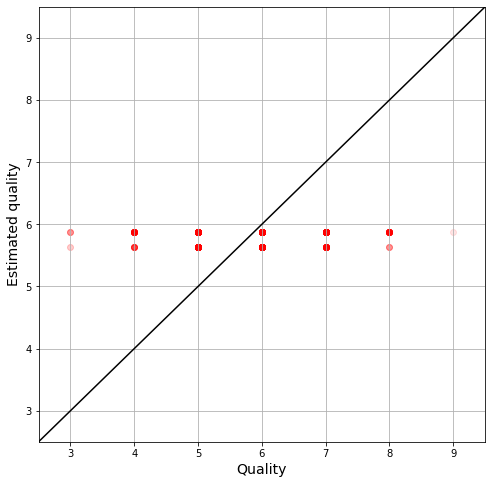

In [58]:
#истинные оценки вин и их предсказания средними по типам на тестовой выборке:

pyplot.figure(figsize(8,8))
pyplot.scatter(y_test, y_test_predictions, color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

# Regressor

In [59]:
#Eсть ещё 11 признаков, описывающих химический состав вин:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
1545,6.5,0.63,0.33,1.80,0.059,16.0,28.0,0.995,3.36,0.64,10.100,6,red
4854,6.2,0.35,0.29,3.90,0.041,22.0,79.0,0.990,3.10,0.59,12.067,6,white
3018,6.8,0.22,0.31,6.90,0.037,33.0,121.0,0.992,3.02,0.39,11.900,8,white
2807,7.5,0.18,0.72,9.60,0.039,53.0,151.0,0.998,3.03,0.46,8.900,5,white
502,10.4,0.44,0.73,6.55,0.074,38.0,76.0,0.999,3.17,0.85,12.000,7,red


C:\Users\Olya\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  import sys


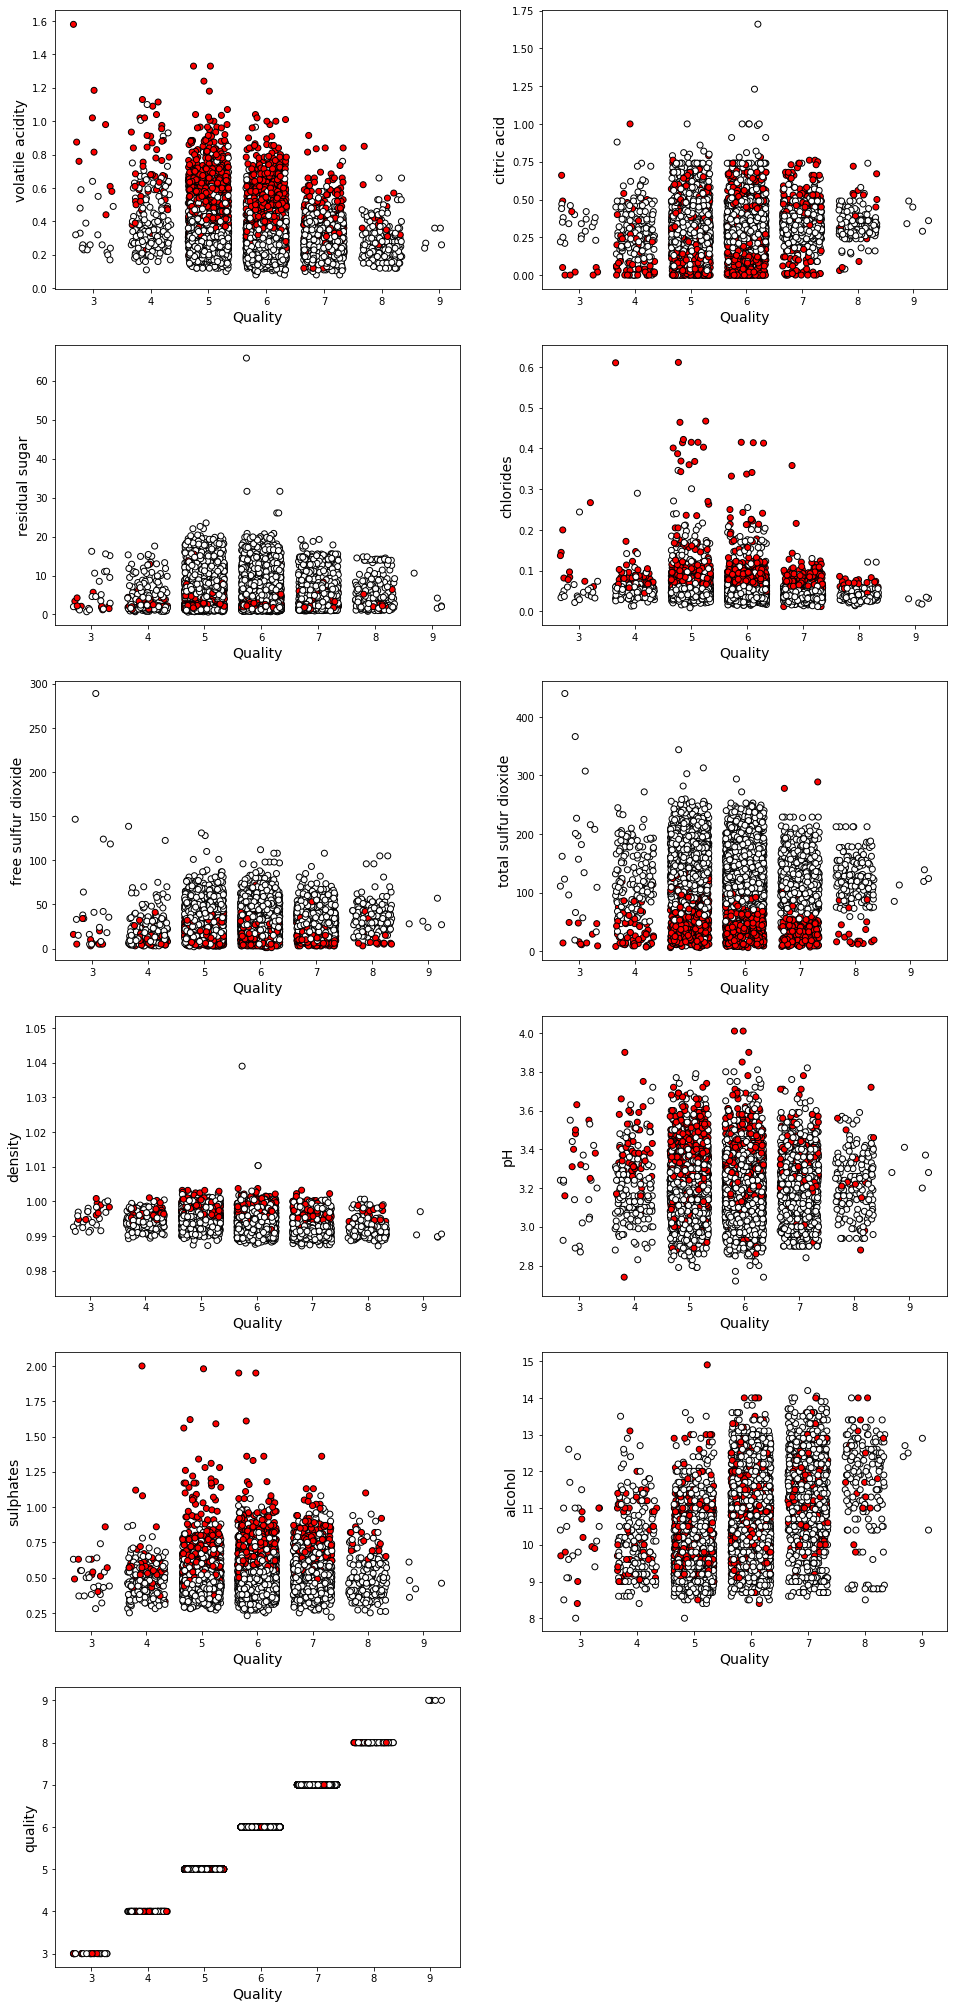

In [63]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

pyplot.figure(figsize(16, 36))
for i in range (1, 12):
    pyplot.subplot(6, 2, i)
    pyplot.scatter(jitter(wine['quality']), wine.ix[:, i], color=wine["color"], edgecolors="black")
    pyplot.xlabel('Quality', fontsize=14)
    pyplot.ylabel(str(wine.columns[i]), fontsize=14)

In [64]:
#Построим для начала линейную регрессионную модель.
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
sqrt(mean_squared_error(lm.predict(X_train), y_train))


0.7331908141169424

In [68]:
sqrt(mean_squared_error(lm.predict(X_test), y_test))

0.7311478995044846

Text(0, 0.5, 'Estimated quality')

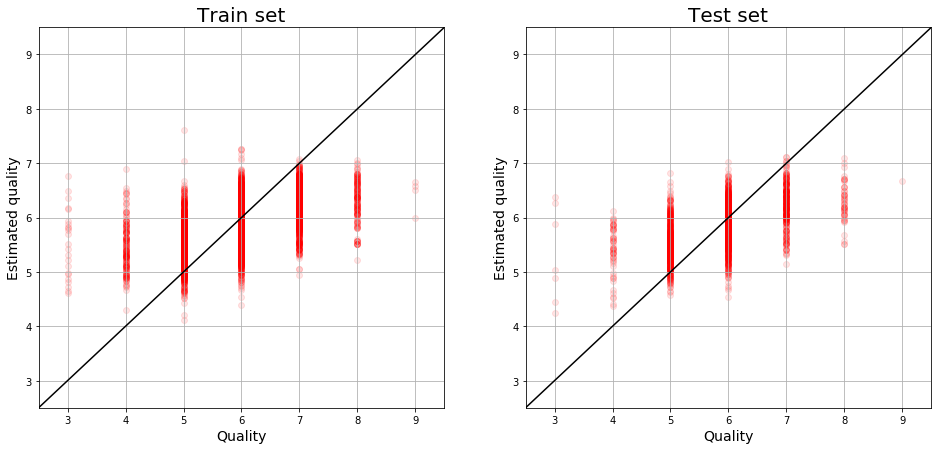

In [69]:
#Истинные оценки вин и их предсказания линейной моделью:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, lm.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, lm.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

In [113]:
#Посчитаем коэффициент детерминации — долю объяснённой моделью дисперсии отклика:
lm.score(X_test, y_test)

0.29691052345060887

In [127]:
#Построим на обучающей выборке случайный лес RandomForest
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)
rf = RandomForestRegressor()


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [128]:
rf.fit(X_train, y_train)
print(rf)

C:\Users\Olya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [116]:
sqrt(mean_squared_error(rf.predict(X_train), y_train))
#Качество выросло ещё сильнее, хотя модель и переобучилась:

0.2734337394181939

In [117]:
sqrt(mean_squared_error(rf.predict(X_test), y_test))

0.638922169330145

Text(0, 0.5, 'Estimated quality')

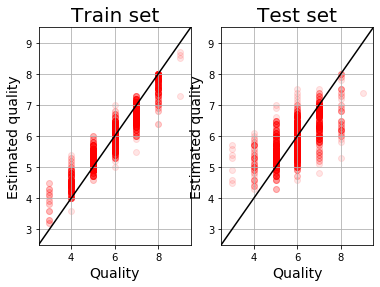

In [118]:
#Истинные оценки вин и их предсказания случайным лесом:
plt.subplot(121)
pyplot.scatter(y_train, rf.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, rf.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

In [119]:
#Коэффициент детерминации для случайного леса
rf.score(X_test, y_test)

0.46309674180270705

C:\Users\Olya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Difference of absolute errors')

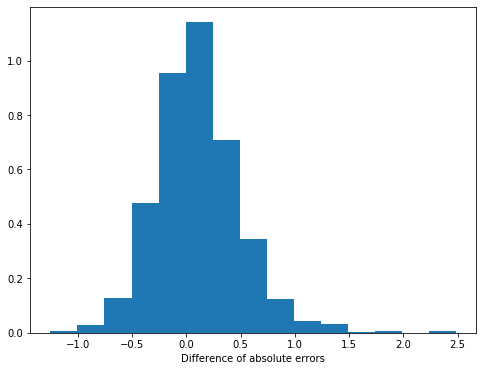

In [121]:
#Сравним ошибки линейной регрессии и случайного леса на тестовой выборке
plt.figure(figsize(8,6))
plt.hist(abs(y_test - lm.predict(X_test)) - abs(y_test - rf.predict(X_test)), bins=15, normed=True)
plt.xlabel('Difference of absolute errors')

In [124]:
tmeans = sm.CompareMeans(sm.DescrStatsW(abs(y_test - lm.predict(X_test))), 
                         sm.DescrStatsW(abs(y_test - rf.predict(X_test))))
# sm.DescrStatsW(значение = 0, альтернатива = 'двусторонняя') - z-тест нулевой гипотезы, что среднее значение равно значению
# sm.CompareMeans - класс для сравнения двух образцов
tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]
#ttest_ind - nроверка на нулевую гипотезу идентичных средств

In [125]:
#95% доверительный интервал для средней разности абсолютных ошибок:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.07732784419955438, 0.13914782171867426)

То есть, используя вместо линейной регрессии наш случайный лес, мы предсказываем экспертную оценку в среднем на 0.077-0.139 баллов точнее.

Посмотрим, какие признаки обладают наибольшей предсказательной способностью:

In [131]:
importances = pd.DataFrame(zip(X_train.columns, rf.feature_importances_))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
10,alcohol,0.251
1,volatile acidity,0.130
5,free sulfur dioxide,0.093
9,sulphates,0.082
3,residual sugar,0.071
6,total sulfur dioxide,0.070
4,chlorides,0.068
8,pH,0.063
2,citric acid,0.057
7,density,0.057


In [ ]:
Cильнее всего на экспертную оценку качества вина влияет содержание алкоголя.